# Comparaison de la sélection de variables avec STABL (Random Forest, XGBoost, Lasso, ElasticNet)

Ce notebook compare la sélection de variables et les performances de classification/régression entre STABL utilisant des modèles d’arbres (Random Forest, XGBoost) avec grid search, et STABL utilisant des modèles linéaires (Lasso, ElasticNet). Les résultats sont évalués par validation croisée, en termes de performances et de nombre de variables sélectionnées.

In [3]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression, Lasso, ElasticNet
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
from stabl.stabl import Stabl
from stabl.adaptive import ALasso, ALogitLasso
from stabl.preprocessing import LowInfoFilter
# from stabl.visualization import plot_fdr_graph
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import clone
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline



## 1. Charger et explorer les données

Nous allons charger un jeu de données tabulaire (exemple : CyTOF.csv et outcome.csv), afficher ses dimensions, types de variables, et quelques statistiques descriptives.

Features shape: (177, 1216)
Outcome shape: (177, 1)
Features columns: ['cMCs_HLADR_GMCSF', 'MDSCs_IkB_GMCSF', 'intMCs_pCREB_GMCSF', 'Granulocytes_pERK_GMCSF', 'MDSCs_pERK_GMCSF', 'cMCs_pERK_GMCSF', 'intMCs_pERK_GMCSF', 'ncMCs_pERK_GMCSF', 'pDCs_pERK_GMCSF', 'Granulocytes_pNFkB_GMCSF'] …
Outcome columns: ['DOS']

=== Statistiques descriptives des features ===
                         count      mean       std       min       25%  \
cMCs_HLADR_GMCSF         177.0  4.668894  0.635174  2.819139  4.419004   
MDSCs_IkB_GMCSF          177.0 -0.192023  0.070885 -0.359435 -0.243705   
intMCs_pCREB_GMCSF       177.0  0.371124  0.192806 -0.228241  0.301780   
Granulocytes_pERK_GMCSF  177.0  0.051222  0.029717 -0.002079  0.031515   
MDSCs_pERK_GMCSF         177.0 -0.222357  0.104227 -0.533919 -0.271677   
...                        ...       ...       ...       ...       ...   
pDCs_pS6_Unstim          151.0  0.372886  0.199852  0.000000  0.278250   
pDCs_pSTAT1_Unstim       151.0  0.011949  0.082

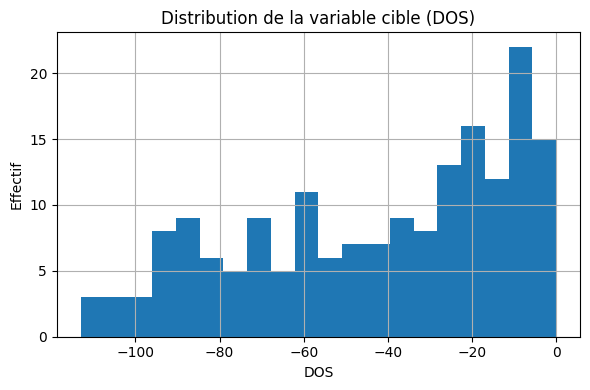

In [4]:
# 1. Charger les données

features_path = "/Users/noeamar/Documents/Stanford/data/olivier_data/ina_13OG_df_168_filtered_allstim_new.csv"
outcome_path = "/Users/noeamar/Documents/Stanford/data/olivier_data/outcome_table_all_pre.csv"

features = pd.read_csv(features_path, index_col=0)
outcome = pd.read_csv(outcome_path, index_col=0, dtype={"DOS": int})

# 2. Garder seulement les patients présents dans les deux fichiers
common_idx = features.index.intersection(outcome.index)
features = features.loc[common_idx]
outcome  = outcome.loc[common_idx]

# 3. Extraire la série cible
y = outcome["DOS"]

# 4. Diagnostic rapide
print("Features shape:", features.shape)
print("Outcome shape:",  outcome.shape)
print("Features columns:", features.columns.tolist()[:10], "…")
print("Outcome columns:",  outcome.columns.tolist())

print("\n=== Statistiques descriptives des features ===")
print(features.describe().T)

print("\n=== Statistiques descriptives de DOS ===")
print(y.describe())

# 5. Histogramme de la variable continue DOS
plt.figure(figsize=(6,4))
y.hist(bins=20)
plt.title("Distribution de la variable cible (DOS)")
plt.xlabel("DOS")
plt.ylabel("Effectif")
plt.tight_layout()
plt.show()


## 2. Définir le préprocessing

Pipeline de préprocessing : imputation, standardisation, filtrage faible variance, filtrage low info.

## Configuration des pipelines STABL avec modèles d’arbres et linéaires

Dans cette section, nous allons configurer plusieurs pipelines de sélection de variables et de modélisation :
- **STABL + Random Forest** : sélection de variables avec STABL utilisant Random Forest comme estimateur, avec recherche de grille (grid search) pour optimiser les hyperparamètres, et validation croisée (cross-validation).
- **STABL + XGBoost** : même principe, mais avec XGBoost comme estimateur.
- **STABL + Lasso** : pipeline linéaire utilisant Lasso.
- **STABL + ElasticNet** : pipeline linéaire utilisant ElasticNet.

Pour chaque pipeline, nous appliquerons la sélection de variables, puis nous évaluerons les performances en cross-validation et le nombre de variables sélectionnées. Les résultats seront comparés à la fin du notebook.

## Cross-validation, sauvegarde des résultats et visualisation

Pour chaque modèle, nous allons :
- Effectuer une cross-validation (stratifiée) sur le dataset.
- Sauvegarder les courbes ROC et PR dans le dossier `Benchmarks results/` avec le nom du modèle et du dataset.
- Sauvegarder les importances des variables sélectionnées et leur nombre.
- Comparer les performances (AUC, accuracy, etc.) et le nombre de variables sélectionnées entre tous les modèles.

Les résultats seront visualisés sous forme de tableaux et de graphes pour faciliter la comparaison.

## Conclusion

Ce notebook permet de comparer la sélection de variables et les performances de classification entre STABL (Random Forest, XGBoost, Lasso, ElasticNet) sur le dataset CyTOF. Les courbes ROC, PR, importances des variables et tableaux de résultats sont sauvegardés dans le dossier `Benchmarks results/` avec des noms explicites pour chaque modèle et dataset. Vous pouvez adapter ce pipeline à d'autres datasets en modifiant la section de chargement des données.

In [ ]:
# Pipeline de préprocessing (à utiliser dans chaque pipeline)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from stabl.preprocessing import LowInfoFilter

preprocessing = Pipeline([
    ("variance_threshold", VarianceThreshold(threshold=0)),
    ("low_info_filter", LowInfoFilter(max_nan_fraction=0.2)),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

In [13]:
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import r2_score

from xgboost import XGBRegressor
from stabl.data import load_onset_data
from stabl.stacked_generalization import stacked_multi_omic

# -------------------------
# 0. Global config
# -------------------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------------------------
# 1. Load data
# -------------------------
print("📥 Loading onset data …")
X_dict, _, y, _, _, _ = load_onset_data(features_path, outcome_path)
print(f"✔ Loaded {len(X_dict)} omics, {y.shape[0]} samples, outcome: {y.name}")

outer_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

# -------------------------
# 2. Pre-processing pipeline
# -------------------------
prepro = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std",     StandardScaler()),
])

# -------------------------
# 3. Hyper-parameter space
# -------------------------
param_dist = {
    "xgb__learning_rate":    [0.03, 0.05, 0.07, 0.1],
    "xgb__n_estimators":     [300, 500, 800],
    "xgb__max_depth":        [2, 3, 4],
    "xgb__min_child_weight": [1, 5, 10],
    "xgb__gamma":            [0, 0.1, 0.3],
    "xgb__subsample":        [0.6, 0.8, 1.0],
    "xgb__colsample_bytree": [0.6, 0.8, 1.0],
    "xgb__reg_alpha":        [0, 0.5, 1, 2],
    "xgb__reg_lambda":       [0.5, 1, 2, 4],
}

inner_cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=RANDOM_STATE)


def make_xgb_pipeline():
    return Pipeline([
        ("prepro", prepro),
        ("xgb", XGBRegressor(
            objective="reg:squarederror",
            random_state=RANDOM_STATE,
            tree_method="hist",
            eval_metric="rmse",
        )),
    ])

# -------------------------
# 4. Per-omic tuning + OOF preds
# -------------------------
print("\n🔧 Hyper‑parameter optimisation par omique …")

preds_train = pd.DataFrame(index=y.index)
best_params_by_omic = {}

for omic_name, X_omic in tqdm(X_dict.items(), desc="Omics", unit="omic"):

    pipe = make_xgb_pipeline()
    rand_xgb = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_dist,
        n_iter=120,
        scoring="r2",
        cv=inner_cv,
        n_jobs=-1,
        verbose=0,
        random_state=RANDOM_STATE,
        refit=True,
    )

    rand_xgb.fit(X_omic, y)  # pas d'early stopping -> évite l'erreur fit_params

    best_params_by_omic[omic_name] = rand_xgb.best_params_
    print(f"✓ {omic_name}: best CV R² = {rand_xgb.best_score_:.3f}")

    # OOF predictions with outer CV
    fold_preds = pd.Series(index=y.index, dtype=float)
    oof_bar = trange(outer_cv.get_n_splits(), desc=f"OOF {omic_name}", leave=False)
    for k, (tr, te) in enumerate(outer_cv.split(X_omic, y)):
        X_tr, X_te = X_omic.iloc[tr], X_omic.iloc[te]
        y_tr       = y.iloc[tr]

        best_pipe = make_xgb_pipeline().set_params(**rand_xgb.best_params_)
        best_pipe.fit(X_tr, y_tr)
        fold_preds.iloc[te] = best_pipe.predict(X_te)
        oof_bar.update(1)
    oof_bar.close()
    preds_train[omic_name] = fold_preds

# -------------------------
# 5. Late-fusion (stacking)
# -------------------------
print("\n🔗 Empilement late‑fusion …")
stacked_df, weights = stacked_multi_omic(preds_train, y, task_type="regression", n_iter=10000)
print("✓ R² stacked = {:.3f}".format(r2_score(y, stacked_df["Stacked Gen. Predictions"])))
print("Poids des omiques :\n", weights)

# -------------------------
# 6. Save artefacts
# -------------------------
output_dir = Path("results_multiomic")
output_dir.mkdir(exist_ok=True)

print("💾 Saving artefacts …")

pd.concat({k: pd.Series(v) for k, v in best_params_by_omic.items()}, axis=1).to_csv(output_dir / "best_params_by_omic.csv")
preds_train.to_csv(output_dir / "preds_per_omic.csv")
stacked_df.to_csv(output_dir / "stacked_predictions.csv")
weights.to_csv(output_dir / "stacked_weights.csv")

print("\n🎉 Pipeline terminé. Résultats enregistrés dans", output_dir)


📥 Loading onset data …
✔ Loaded 8 omics, 177 samples, outcome: DOS

🔧 Hyper‑parameter optimisation par omique …


Omics:   0%|          | 0/8 [00:00<?, ?omic/s]

✓ Unstim: best CV R² = 0.366


Omics:  12%|█▎        | 1/8 [06:27<45:15, 387.97s/omic]

✓ TNFa: best CV R² = 0.162


Omics:  25%|██▌       | 2/8 [07:44<20:29, 204.83s/omic]

✓ LPS: best CV R² = 0.243


Omics:  38%|███▊      | 3/8 [12:22<19:51, 238.30s/omic]

✓ IL246: best CV R² = 0.203


Omics:  50%|█████     | 4/8 [15:50<15:05, 226.26s/omic]

✓ IFNa: best CV R² = 0.303


Omics:  62%|██████▎   | 5/8 [21:11<13:01, 260.46s/omic]

✓ GMCSF: best CV R² = 0.242


Omics:  75%|███████▌  | 6/8 [22:34<06:39, 199.96s/omic]

✓ PI: best CV R² = 0.199


Omics:  88%|████████▊ | 7/8 [29:02<04:21, 261.63s/omic]

✓ IL33: best CV R² = 0.149


Omics: 100%|██████████| 8/8 [32:16<00:00, 242.10s/omic]



🔗 Empilement late‑fusion …
✓ R² stacked = 0.356
Poids des omiques :
         Associated weight
Unstim           7.800520
TNFa             2.774232
LPS              0.005271
IL246            0.581570
IFNa             5.529998
GMCSF            2.854811
PI               1.929546
IL33             0.496409
💾 Saving artefacts …

🎉 Pipeline terminé. Résultats enregistrés dans results_multiomic


In [14]:
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor          # ← RF
from stabl.data import load_onset_data
from stabl.stacked_generalization import stacked_multi_omic

# ------------------------- 0. Global config
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ------------------------- 1. Load data
print("📥 Loading onset data …")
X_dict, _, y, _, _, _ = load_onset_data(features_path, outcome_path)
print(f"✔ Loaded {len(X_dict)} omics, {y.shape[0]} samples, outcome: {y.name}")

outer_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

# ------------------------- 2. Pre-processing pipeline
prepro = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std",     StandardScaler()),
])

# ------------------------- 3. Hyper-parameter space (RF)
param_dist = {
    "rf__n_estimators"     : [300, 500, 800, 1200],
    "rf__max_depth"        : [None, 5, 10, 20],
    "rf__max_features"     : [0.2, 0.4, 0.6, "auto"],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf" : [1, 2, 4],
    "rf__bootstrap"        : [True, False],
}

inner_cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=RANDOM_STATE)

def make_rf_pipeline():
    return Pipeline([
        ("prepro", prepro),
        ("rf", RandomForestRegressor(
            random_state   = RANDOM_STATE,
            n_jobs         = -1,        # parallélisme interne
            oob_score      = False,
        )),
    ])

# ------------------------- 4. Per-omic tuning + OOF preds
print("\n🔧 Hyper-parameter optimisation RF par omique …")

preds_train = pd.DataFrame(index=y.index)
best_params_by_omic = {}

for omic_name, X_omic in tqdm(X_dict.items(), desc="Omics", unit="omic"):

    pipe = make_rf_pipeline()
    rand_rf = RandomizedSearchCV(
        estimator              = pipe,
        param_distributions    = param_dist,
        n_iter                 = 120,
        scoring                = "r2",
        cv                     = inner_cv,
        n_jobs                 = -1,
        verbose                = 0,
        random_state           = RANDOM_STATE,
        refit                  = True,
    )

    rand_rf.fit(X_omic, y)

    best_params_by_omic[omic_name] = rand_rf.best_params_
    print(f"✓ {omic_name}: best CV R² = {rand_rf.best_score_:.3f}")

    # OOF predictions with outer CV
    fold_preds = pd.Series(index=y.index, dtype=float)
    oof_bar = trange(outer_cv.get_n_splits(), desc=f"OOF {omic_name}", leave=False)
    for k, (tr, te) in enumerate(outer_cv.split(X_omic, y)):
        X_tr, X_te = X_omic.iloc[tr], X_omic.iloc[te]
        y_tr       = y.iloc[tr]

        best_pipe = make_rf_pipeline().set_params(**rand_rf.best_params_)
        best_pipe.fit(X_tr, y_tr)
        fold_preds.iloc[te] = best_pipe.predict(X_te)
        oof_bar.update(1)
    oof_bar.close()
    preds_train[omic_name] = fold_preds

# ------------------------- 5. Late-fusion (stacking)
print("\n🔗 Empilement late-fusion …")
stacked_df, weights = stacked_multi_omic(preds_train, y, task_type="regression", n_iter=10000)
print("✓ R² stacked = {:.3f}".format(r2_score(y, stacked_df["Stacked Gen. Predictions"])))
print("Poids des omiques :\n", weights)

# ------------------------- 6. Save artefacts
output_dir = Path("results_multiomic_RF")
output_dir.mkdir(exist_ok=True)

print("💾 Saving artefacts …")
pd.concat({k: pd.Series(v) for k, v in best_params_by_omic.items()}, axis=1).to_csv(output_dir / "best_params_by_omic.csv")
preds_train.to_csv(output_dir / "preds_per_omic.csv")
stacked_df.to_csv(output_dir / "stacked_predictions.csv")
weights.to_csv(output_dir / "stacked_weights.csv")

print("\n🎉 Pipeline terminé. Résultats enregistrés dans", output_dir)


📥 Loading onset data …
✔ Loaded 8 omics, 177 samples, outcome: DOS

🔧 Hyper-parameter optimisation RF par omique …


Omics:   0%|          | 0/8 [00:00<?, ?omic/s]

✓ Unstim: best CV R² = 0.313


Omics:  12%|█▎        | 1/8 [11:21<1:19:32, 681.79s/omic]

✓ TNFa: best CV R² = 0.173


Omics:  25%|██▌       | 2/8 [15:37<43:07, 431.20s/omic]  

✓ LPS: best CV R² = 0.194


Omics:  38%|███▊      | 3/8 [24:41<40:14, 482.81s/omic]

✓ IL246: best CV R² = 0.181


Omics:  50%|█████     | 4/8 [31:42<30:33, 458.34s/omic]

✓ IFNa: best CV R² = 0.211


Omics:  62%|██████▎   | 5/8 [41:43<25:29, 509.83s/omic]

✓ GMCSF: best CV R² = 0.241


Omics:  75%|███████▌  | 6/8 [46:21<14:21, 430.82s/omic]

✓ PI: best CV R² = 0.166


Omics:  88%|████████▊ | 7/8 [1:33:02<20:05, 1205.81s/omic]

✓ IL33: best CV R² = 0.177


Omics: 100%|██████████| 8/8 [2:21:17<00:00, 1059.72s/omic]



🔗 Empilement late-fusion …
✓ R² stacked = 0.291
Poids des omiques :
         Associated weight
Unstim           9.080349
TNFa             0.583110
LPS              3.748372
IL246            0.141490
IFNa             1.842795
GMCSF            9.622259
PI               0.784953
IL33             1.454066
💾 Saving artefacts …

🎉 Pipeline terminé. Résultats enregistrés dans results_multiomic_RF


In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import r2_score

from lightgbm import LGBMRegressor                      # ← LightGBM
from stabl.data import load_onset_data
from stabl.stacked_generalization import stacked_multi_omic

# ------------------------- 0. Global config
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ------------------------- 1. Load data
print("📥 Loading onset data …")
X_dict, _, y, _, _, _ = load_onset_data(features_path, outcome_path)
print(f"✔ Loaded {len(X_dict)} omics, {y.shape[0]} samples, outcome: {y.name}")

outer_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=RANDOM_STATE)

# ------------------------- 2. Pre-processing pipeline
prepro = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("std",     StandardScaler()),
])

# ------------------------- 3. Hyper-parameter space (LightGBM)
param_dist = {
    "lgb__learning_rate" : [0.01, 0.03, 0.05, 0.07],
    "lgb__n_estimators"  : [500, 800, 1200],
    "lgb__max_depth"     : [-1, 4, 6, 8],
    "lgb__num_leaves"    : [31, 63, 127, 255],       # doit rester ≤ 2**max_depth
    "lgb__subsample"     : [0.6, 0.8, 1.0],
    "lgb__colsample_bytree":[0.6, 0.8, 1.0],
    "lgb__min_child_samples":[5, 10, 20],
    "lgb__reg_alpha"     : [0, 0.5, 1],
    "lgb__reg_lambda"    : [0, 0.5, 1],
}

inner_cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=RANDOM_STATE)

def make_lgb_pipeline():
    return Pipeline([
        ("prepro", prepro),
        ("lgb", LGBMRegressor(
            objective     = "regression",
            random_state  = RANDOM_STATE,
            boosting_type = "gbdt",
            n_jobs        = -1,
            verbose       = -1,
        )),
    ])

# ------------------------- 4. Per-omic tuning + OOF preds
print("\n🔧 Hyper-parameter optimisation LightGBM par omique …")

preds_train = pd.DataFrame(index=y.index)
best_params_by_omic = {}

for omic_name, X_omic in tqdm(X_dict.items(), desc="Omics", unit="omic"):

    pipe = make_lgb_pipeline()
    rand_lgb = RandomizedSearchCV(
        estimator           = pipe,
        param_distributions = param_dist,
        n_iter              = 120,
        scoring             = "r2",
        cv                  = inner_cv,
        n_jobs              = -1,
        random_state        = RANDOM_STATE,
        verbose             = 0,
        refit               = True,
    )

    rand_lgb.fit(X_omic, y)

    best_params_by_omic[omic_name] = rand_lgb.best_params_
    print(f"✓ {omic_name}: best CV R² = {rand_lgb.best_score_:.3f}")

    # OOF predictions with outer CV
    fold_preds = pd.Series(index=y.index, dtype=float)
    oof_bar = trange(outer_cv.get_n_splits(), desc=f"OOF {omic_name}", leave=False)
    for k, (tr, te) in enumerate(outer_cv.split(X_omic, y)):
        X_tr, X_te = X_omic.iloc[tr], X_omic.iloc[te]
        y_tr       = y.iloc[tr]

        best_pipe = make_lgb_pipeline().set_params(**rand_lgb.best_params_)
        best_pipe.fit(X_tr, y_tr)
        fold_preds.iloc[te] = best_pipe.predict(X_te)
        oof_bar.update(1)
    oof_bar.close()
    preds_train[omic_name] = fold_preds

# ------------------------- 5. Late-fusion (stacking)
print("\n🔗 Empilement late-fusion …")
stacked_df, weights = stacked_multi_omic(preds_train, y, task_type="regression", n_iter=10000)
print("✓ R² stacked = {:.3f}".format(r2_score(y, stacked_df["Stacked Gen. Predictions"])))
print("Poids des omiques :\n", weights)

# ------------------------- 6. Save artefacts
output_dir = Path("results_multiomic_LightGBM")
output_dir.mkdir(exist_ok=True)

print("💾 Saving artefacts …")
pd.concat({k: pd.Series(v) for k, v in best_params_by_omic.items()}, axis=1).to_csv(output_dir / "best_params_by_omic.csv")
preds_train.to_csv(output_dir / "preds_per_omic.csv")
stacked_df.to_csv(output_dir / "stacked_predictions.csv")
weights.to_csv(output_dir / "stacked_weights.csv")

print("\n🎉 Pipeline terminé. Résultats enregistrés dans", output_dir)


📥 Loading onset data …
✔ Loaded 8 omics, 177 samples, outcome: DOS

🔧 Hyper-parameter optimisation LightGBM par omique …


Omics:   0%|          | 0/8 [00:00<?, ?omic/s]

✓ Unstim: best CV R² = 0.319


Omics:  12%|█▎        | 1/8 [39:54<4:39:21, 2394.50s/omic]

✓ TNFa: best CV R² = 0.158


Omics:  25%|██▌       | 2/8 [1:10:36<3:26:56, 2069.43s/omic]

✓ LPS: best CV R² = 0.217


Omics:  38%|███▊      | 3/8 [1:41:24<2:44:02, 1968.44s/omic]

✓ IL246: best CV R² = 0.186


Omics:  50%|█████     | 4/8 [2:11:15<2:06:32, 1898.22s/omic]

✓ IFNa: best CV R² = 0.264


Omics:  62%|██████▎   | 5/8 [2:41:38<1:33:33, 1871.13s/omic]

✓ GMCSF: best CV R² = 0.238


Omics:  75%|███████▌  | 6/8 [3:19:44<1:07:04, 2012.26s/omic]

✓ PI: best CV R² = 0.214


Omics:  88%|████████▊ | 7/8 [3:49:57<32:27, 1947.20s/omic]  

✓ IL33: best CV R² = 0.154


Omics: 100%|██████████| 8/8 [4:19:36<00:00, 1947.08s/omic]



🔗 Empilement late-fusion …
✓ R² stacked = 0.351
Poids des omiques :
         Associated weight
Unstim           8.727782
TNFa             4.125899
LPS              1.906575
IL246            1.472442
IFNa             4.209141
GMCSF            0.172884
PI               1.210561
IL33             0.036981
💾 Saving artefacts …

🎉 Pipeline terminé. Résultats enregistrés dans results_multiomic_LightGBM


In [ ]:
# ===============================
# 1. Imports et configuration générale
# ===============================
import os
import shutil
import numpy as np
import pandas as pd
from stabl import data
from stabl.multi_omic_pipelines import multi_omic_stabl_cv
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.linear_model import LogisticRegression
from stabl.stabl import Stabl
from stabl.adaptive import ALogitLasso
from sklearn.base import clone
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso
from stabl.data import load_onset_data
from pathlib import Path
from sklearn.linear_model import ElasticNet

np.random.seed(42)

# ===============================
# 2. Définition des splits de validation croisée
# ===============================
# Outer CV pour l'évaluation globale, inner CV pour la recherche d'hyperparamètres
outer_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
inner_cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# ===============================
# 3. Définition des estimateurs et grilles d'hyperparamètres
# ===============================
artificial_type = "knockoff"  # ou "random_permutation"

# Lasso
lasso = Lasso(max_iter=int(1e6), random_state=42)
lasso_cv = GridSearchCV(lasso, param_grid={"alpha": np.logspace(-2, 2, 30)}, scoring="r2", cv=inner_cv, n_jobs=-1)

#ElasticNet
en = ElasticNet(max_iter=int(1e6), random_state=42)
en_params = {"alpha": np.logspace(-2, 2, 10), "l1_ratio": [0.5, 0.7, 0.9]}
en_cv = GridSearchCV(en, param_grid=en_params, scoring="r2", cv=inner_cv, n_jobs=-1)

# RandomForest
rf = RandomForestRegressor(random_state=42, max_features=0.2)
rf_grid = {"max_depth": [3, 5, 7, 9, 11]}
rf_cv = GridSearchCV(rf, scoring='r2', param_grid=rf_grid, cv=inner_cv, n_jobs=-1)

# XGBoost
xgb = XGBRegressor(random_state=42, importance_type="gain", objective="reg:squarederror")
xgb_grid = {"max_depth": [3, 6, 9], "reg_alpha": [0, 0.5, 1, 2]}
xgb_cv = GridSearchCV(xgb, scoring='r2', param_grid=xgb_grid, cv=inner_cv, n_jobs=-1)

# CatBoost
cb = CatBoostRegressor(random_state=42)
cb_grid = {"depth": [3, 5, 7], "learning_rate": [0.01, 0.1, 0.2], "l2_leaf_reg": [1, 3, 5]}
cb_cv = GridSearchCV(cb, scoring='r2', param_grid=cb_grid, cv=inner_cv, n_jobs=-1, verbose=0)

# LightGBM
lgb = LGBMRegressor(random_state=42)
lgb_grid = {"max_depth": [4, 6, 8], "learning_rate": [0.01, 0.1], "num_leaves": [31, 63, 127], "reg_alpha": [0, 1], "reg_lambda": [0, 1]}
lgb_cv = GridSearchCV(estimator=lgb, param_grid=lgb_grid, scoring="r2", cv=inner_cv, n_jobs=-1)

# ===============================
# 4. Définition des estimateurs STABL
# ===============================
stabl_lasso = Stabl(
    base_estimator=lasso,
    n_bootstraps=100,
    artificial_type=artificial_type,
    artificial_proportion=1.,
    replace=False,
    fdr_threshold_range=np.arange(0.1, 1, 0.01),
    sample_fraction=0.5,
    random_state=42,
    lambda_grid={"alpha": np.logspace(-2, 2, 10)},
    verbose=1
)

stabl_en = clone(stabl_lasso).set_params(
    base_estimator=en,
    n_bootstraps=100,
    lambda_grid=[{"C": np.logspace(-2, 1, 5), "l1_ratio": [0.5, 0.9]}],
    verbose=1
)

stabl_rf = clone(stabl_lasso).set_params(
    base_estimator=rf,
    n_bootstraps=100,
    lambda_grid=rf_grid,
    verbose=1
)

stabl_xgb = clone(stabl_lasso).set_params(
    base_estimator=xgb,
    n_bootstraps=100,
    lambda_grid=[xgb_grid],
    verbose=1
)

stabl_cb = clone(stabl_lasso).set_params(
    base_estimator=cb,
    n_bootstraps=100,
    lambda_grid=[cb_grid],
    verbose=1
)

stabl_lgb = clone(stabl_lasso).set_params(
    base_estimator=lgb,
    n_bootstraps=100,
    lambda_grid=[lgb_grid],
    verbose=1
)

# ===============================
# 5. Dictionnaire des estimateurs pour le benchmark
# ===============================
estimators = {
    "lasso": lasso_cv,
    "rf": rf_cv,
    "xgb": xgb_cv,
#   "cb": cb_cv,
#   "lgb": lgb_cv,
    "stabl_lasso": stabl_lasso,
    "stabl_rf": stabl_rf,
    "stabl_xgb": stabl_xgb,
#   "stabl_cb" : stabl_cb,
#   "stabl_lgb": stabl_lgb,
    }

models = [
    "Lasso",
    "RandomForest",
    "XGBoost",
#    "CatBoost",
#    "LightGBM",
    "STABL Lasso",
    "STABL RandomForest",
    "STABL XGBoost",
#    "STABL CatBoost"
#    "STABL LightGBM"
]


# juste après avoir construit ton dict estimators, ajoute :
estimators["en"]        = estimators["lasso"]        # placeholder vide
estimators["stabl_en"]  = estimators["stabl_lasso"]  # placeholder vide

estimators["cb"]        = estimators["lasso"]        # placeholder vide
estimators["stabl_cb"]  = estimators["stabl_lasso"]  # placeholder vide

estimators["lgb"]        = estimators["lasso"]        # placeholder vide
estimators["stabl_lgb"]  = estimators["stabl_lasso"]  # placeholder vide


# final_classifiers = {"Logit": LogisticRegression(penalty="l1", solver="liblinear", class_weight="balanced", max_iter=int(1e6), random_state=42),
#                      "RandomForest": RandomForestClassifier(n_estimators=500, random_state=42),
#                      "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", n_estimators=200,random_state=42),
#                     }


# ===============================
# 6. Chargement des données (exemple COVID-19)
# ===============================
# X_train, X_valid, y_train, y_valid, ids, task_type = data.load_covid_19("data/COVID-19")
X_train, X_val, y_train, y_val, groups, task_type = load_onset_data(features_path, outcome_path)

# ===============================
# 7. Lancement du benchmark multi-omic STABL
# ===============================
save_path = "./Benchmarks results/Regresssion data Olivier + LineReg/KO"

# Nettoyage du dossier de sauvegarde si besoin
if os.path.exists(save_path):
    shutil.rmtree(save_path)

print("Run CV on Olivier dataset")
# print(groups.value_counts())

multi_omic_stabl_cv(
    data_dict=X_train,
    y=y_train,
    outer_splitter=outer_cv,
    estimators=estimators,
    task_type=task_type,
    save_path=save_path,
    outer_groups=groups,
    early_fusion=False,
    late_fusion=True,
    n_iter_lf=1000,
    models=models
)

In [ ]:
# ===============================
# 1. Imports et configuration générale
# ===============================
import os
import shutil
import numpy as np
import pandas as pd
from stabl import data
from stabl.multi_omic_pipelines import multi_omic_stabl_cv_combined  # nouvelle fonction
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from stabl.stabl import Stabl
from sklearn.base import clone
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso, ElasticNet
from stabl.data import load_onset_data
from pathlib import Path

np.random.seed(42)

features_path = "/Users/noeamar/Documents/Stanford/data/olivier_data/ina_13OG_df_168_filtered_allstim_new.csv"
outcome_path = "/Users/noeamar/Documents/Stanford/data/olivier_data/outcome_table_all_pre.csv"

# ===============================
# 2. Définition des splits de validation croisée
# ===============================
outer_cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
inner_cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# ===============================
# 3. Définition des estimateurs et grilles d'hyperparamètres
# ===============================
artificial_type = "knockoff"
# base estimators
lasso = Lasso(max_iter=int(1e6), random_state=42)
lasso_cv = GridSearchCV(lasso, {'alpha': np.logspace(-2,2,30)}, scoring='r2', cv=inner_cv, n_jobs=-1)

en = ElasticNet(max_iter=int(1e6), random_state=42)
en_cv = GridSearchCV(en, {'alpha': np.logspace(-2,2,10), 'l1_ratio':[0.5,0.7,0.9]}, scoring='r2', cv=inner_cv, n_jobs=-1)

rf = RandomForestRegressor(random_state=42, max_features=0.2)
rf_cv = GridSearchCV(rf, {'max_depth':[3,5,7,9,11]}, scoring='r2', cv=inner_cv, n_jobs=-1)

xgb = XGBRegressor(random_state=42, importance_type='gain', objective='reg:squarederror')
xgb_cv = GridSearchCV(xgb, {'max_depth':[3,6,9], 'reg_alpha':[0,0.5,1,2]}, scoring='r2', cv=inner_cv, n_jobs=-1)

cb = CatBoostRegressor(random_state=42)
cb_cv = GridSearchCV(cb, {'depth':[3,5,7], 'learning_rate':[0.01,0.1,0.2], 'l2_leaf_reg':[1,3,5]}, scoring='r2', cv=inner_cv, n_jobs=-1, verbose=0)

lgb = LGBMRegressor(random_state=42)
lgb_cv = GridSearchCV(lgb, {'max_depth':[4,6,8], 'learning_rate':[0.01,0.1], 'num_leaves':[31,63,127], 'reg_alpha':[0,1], 'reg_lambda':[0,1]}, scoring='r2', cv=inner_cv, n_jobs=-1)

# ===============================
# 4. Définition des estimateurs STABL
# ===============================
stabl_lasso = Stabl(base_estimator=lasso, n_bootstraps=100, artificial_type=artificial_type,
                    artificial_proportion=1., replace=False,
                    fdr_threshold_range=np.arange(0.1,1,0.01), sample_fraction=0.5,
                    random_state=42, lambda_grid={'alpha':np.logspace(-2,2,10)}, verbose=1)
stabl_rf = clone(stabl_lasso).set_params(base_estimator=rf, lambda_grid={'max_depth':[3,5,7,9,11]})
stabl_xgb = clone(stabl_lasso).set_params(base_estimator=xgb, lambda_grid=[{'max_depth':[3,6,9], 'reg_alpha':[0,0.5,1,2]}])
stabl_cb  = clone(stabl_lasso).set_params(base_estimator=cb, lambda_grid=[{'depth':[3,5,7], 'learning_rate':[0.01,0.1,0.2], 'l2_leaf_reg':[1,3,5]}])
stabl_lgb = clone(stabl_lasso).set_params(base_estimator=lgb, lambda_grid=[{'max_depth':[4,6,8], 'learning_rate':[0.01,0.1], 'num_leaves':[31,63,127], 'reg_alpha':[0,1], 'reg_lambda':[0,1]}])

# ===============================
# 5. Dictionnaire des estimateurs pour le benchmark
# ===============================
estimators = {
    'lasso': lasso_cv,
    'rf':   rf_cv,
    'xgb':  xgb_cv,
#    'cb':   cb_cv,
#    'lgb':  lgb_cv,
    'stabl_lasso': stabl_lasso,
    'stabl_rf':    stabl_rf,
    'stabl_xgb':   stabl_xgb,
#    'stabl_cb':    stabl_cb,
#    'stabl_lgb':   stabl_lgb
}
models = [
    'Lasso',
    'RandomForest',
    'XGBoost',
#    'CatBoost',
#    'LightGBM',
    'STABL Lasso',
    'STABL RandomForest',
    'STABL XGBoost',
#    'STABL CatBoost',
#    'STABL LightGBM',
    'STABL_Combined'
]

# ===============================
# 6. Chargement des données
# ===============================
X_train, X_val, y_train, y_val, groups, task_type = load_onset_data(features_path, outcome_path)

# ===============================
# 7. Lancement du benchmark multi-omic STABL combiné
# ===============================
save_path = './Benchmarks results/Combined Selection/KO'
if os.path.exists(save_path): shutil.rmtree(save_path)

# juste après avoir construit ton dict estimators, ajoute :
estimators["en"]        = estimators["lasso"]        # placeholder vide
estimators["stabl_en"]  = estimators["stabl_lasso"]  # placeholder vide

estimators["cb"]        = estimators["lasso"]        # placeholder vide
estimators["stabl_cb"]  = estimators["stabl_lasso"]  # placeholder vide

estimators["lgb"]        = estimators["lasso"]        # placeholder vide
estimators["stabl_lgb"]  = estimators["stabl_lasso"]  # placeholder vide

multi_omic_stabl_cv_combined(
    data_dict     = X_train,
    y             = y_train,
    outer_splitter= outer_cv,
    estimators    = estimators,
    task_type     = task_type,
    save_path     = save_path,
    outer_groups  = groups,
    early_fusion  = False,
    late_fusion   = False,
    n_iter_lf     = 1000,
    vote_weights  = [0.4, 0.3, 0.3], # Poids pour Lasso, RF, XGB
    fdr_alpha     = 0.3,
    models        = models
)


/Users/noeamar/Documents/Stanford/venv/lib/python3.11/site-packages/stabl/multi_omic_pipelines.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Outer fold:   0%|          | 0/15 [00:00<?, ?it/s]

Stabl progress: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]

Outer fold:   7%|▋         | 1/15 [02:09<30:06, 129.05s/it]


Stabl progress: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s]

Outer fold:  13%|█▎        | 2/15 [04:42<31:00, 143.12s/it]


Stabl progress: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]

Outer fold:  20%|██        | 3/15 [07:10<29:07, 145.63s/it]


Stabl progress: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]

Outer fold:  27%|██▋       | 4/15 [09:37<26:46, 146.04s/it]


Stabl progress: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

Outer fold:  33%|███▎      | 5/15 [12:05<24:28, 146.83s/it]


Stabl progress: 100%|██████████| 12/12 [00:10<00:00,  1.17it/s]

Outer fold:  40%|████      | 6/15 [14:36<22:13, 148.19s/it]


Stabl progress: 100%|██████████| 12/12 [00:10<00:00,  1.15it/s]

Outer fold:  47%|████▋     | 7/15 [17:17<20:20, 152.57s/it]


Stabl progress: 100%|██████████| 12/12 [00:10<00:00,  1.09it/s]

Outer fold:  53%|█████▎    | 8/15 [20:03<18:17, 156.75s/it]


Stabl progress: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]

Outer fold:  60%|██████    | 9/15 [22:55<16:08, 161.34s/it]


Stabl progress: 100%|██████████| 12/12 [00:15<00:00,  1.33s/it]

Outer fold:  67%|██████▋   | 10/15 [25:52<13:51, 166.34s/it]


Stabl progress: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s]

Outer fold:  73%|███████▎  | 11/15 [28:49<11:17, 169.43s/it]


Stabl progress: 100%|██████████| 12/12 [00:11<00:00,  1.09it/s]

Outer fold:  80%|████████  | 12/15 [31:37<08:27, 169.00s/it]


Stabl progress: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s]

Outer fold:  87%|████████▋ | 13/15 [34:31<05:41, 170.54s/it]


Stabl progress: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]

Outer fold:  93%|█████████▎| 14/15 [37:42<02:56, 176.83s/it]


Stabl progress: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]

Outer fold: 100%|██████████| 15/15 [40:45<00:00, 163.03s/it]

Lasso 99_G1   -43.105634
74_G2   -42.591549
72_G3   -41.425532
1_G3    -42.894366
21_G2   -43.007092
           ...    
51_G2   -40.737589
86_G2   -43.007092
56_G2   -42.591549
2_G2    -43.105634
14_G1   -42.542254
Length: 177, dtype: float64
RandomForest 99_G1   -43.105634
74_G2   -42.591549
72_G3   -41.425532
1_G3    -42.894366
21_G2   -43.007092
           ...    
51_G2   -40.737589
86_G2   -43.007092
56_G2   -42.591549
2_G2    -43.105634
14_G1   -42.542254
Length: 177, dtype: float64
XGBoost 99_G1   -43.105634
74_G2   -42.591549
72_G3   -41.425532
1_G3    -42.894366
21_G2   -43.007092
           ...    
51_G2   -40.737589
86_G2   -43.007092
56_G2   -42.591549
2_G2    -43.105634
14_G1   -42.542254
Length: 177, dtype: float64
STABL Lasso 99_G1   -43.105634
74_G2   -42.591549
72_G3   -41.425532
1_G3    -42.894366
21_G2   -43.007092
           ...    
51_G2   -40.737589
86_G2   -43.007092
56_G2   -42.591549
2_G2    -43.105634
14_G1   -42.542254
Length: 177, dtype: float64
STABL RandomF

{'Lasso':            Fold1      Fold2     Fold3      Fold4      Fold5      Fold6  \
 99_G1        NaN        NaN -43.34507        NaN        NaN        NaN   
 74_G2        NaN        NaN       NaN        NaN -42.591549        NaN   
 72_G3        NaN -41.425532       NaN        NaN        NaN        NaN   
 1_G3         NaN        NaN       NaN -42.894366        NaN        NaN   
 21_G2        NaN -41.425532       NaN        NaN        NaN        NaN   
 ...          ...        ...       ...        ...        ...        ...   
 51_G2        NaN        NaN -43.34507        NaN        NaN -40.737589   
 86_G2 -42.191489        NaN       NaN        NaN        NaN        NaN   
 56_G2        NaN        NaN       NaN        NaN -42.591549        NaN   
 2_G2         NaN        NaN       NaN -42.894366        NaN        NaN   
 14_G1        NaN        NaN       NaN        NaN -42.591549 -40.737589   
 
            Fold7  Fold8      Fold9     Fold10  Fold11     Fold12     Fold13  \
 99_G1   

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# ------------------------------------------------------------------
# 1) Charger le fichier CSV
#    ➜ remplace "results_metrics.csv" par le chemin réel de ton CSV
# ------------------------------------------------------------------
csv_path = "/Users/noeamar/Documents/Stanford/Benchmarks results/Regression data Olivier + XGB/KO/Summary/Scores training CV.csv"
df = pd.read_csv(csv_path, index_col=0)

# ------------------------------------------------------------------
# 2) Extraire médiane, borne basse et borne haute
#    Exemple "0.852 [0.735, 0.943]"  →  median=0.852, low=0.735, high=0.943
# ------------------------------------------------------------------
pattern = re.compile(r"([0-9.]+)\s*\[\s*([0-9.]+)\s*,\s*([0-9.]+)\s*\]")

median_df, low_df, high_df = pd.DataFrame(index=df.index), pd.DataFrame(index=df.index), pd.DataFrame(index=df.index)

for col in df.columns:
    med, low, high = [], [], []
    for val in df[col]:
        m = pattern.match(str(val))
        if m:
            med_val, low_val, high_val = map(float, m.groups())
        else:                 # si la cellule ne suit pas le pattern
            med_val = low_val = high_val = float(val)
        med.append(med_val); low.append(low_val); high.append(high_val)
    median_df[col] = med
    low_df[col]    = low
    high_df[col]   = high

# ------------------------------------------------------------------
# 3) Un bar-plot par métrique avec barres d’erreur (CI)
#    (un graphique indépendant par métrique, sans sous-plots)
# ------------------------------------------------------------------
for metric in median_df.columns:
    med  = median_df[metric]
    lower_err = med - low_df[metric]
    upper_err = high_df[metric] - med
    yerr = [lower_err, upper_err]

    plt.figure()
    plt.bar(med.index, med.values)
    plt.errorbar(x=range(len(med)), y=med.values, yerr=yerr, fmt='none', capsize=5)
    plt.title(f"{metric} (median ± CI)")
    plt.ylabel(metric)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
